In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import xgboost as xgb
import numpy as np
import hashlib
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, auc
from sklearn.model_selection import train_test_split
from trainer_lib.transformers import CategoricalLimitTransformer
from trainer_lib.transformers import SelectFeaturesTransfomer
from trainer_lib.transformers import CallDurationTransformer 
from trainer_lib.transformers import TimeOfDayTransformer
from trainer_lib.transformers import MonthNameTransformer
from trainer_lib.transformers import EducationTransformer
from trainer_lib.transformers import DatasetCleanerPipeline
from trainer_lib.transformers import OutcomeTransformer

In [12]:
from trainer_lib import DataManager
np.random.seed(12345)
# The instantiation will fetch data and docs if it is the first time being run
mngr = DataManager(save_path="../data/raw/", report_path="../reports/")
X,y = mngr.train
X_train, X_test, y_train, y_test = mngr.train_test

In [13]:
hashlib.sha1(pd.util.hash_pandas_object(X_train).values).hexdigest() 

'39b2065117b0a441fe4539e0e77d3961a27793bf'

In [84]:
X.Job.unique()

array(['management', 'blue-collar', 'student', 'technician', 'admin.',
       'services', 'self-employed', 'retired', nan, 'housemaid',
       'entrepreneur', 'unemployed'], dtype=object)

In [81]:
# Model columns
ONE_HOT_CATEGORICAL_COLUMNS = [
    "Job",
    "Marital", 
    "Communication", 
    "CallTimeOfDay"
]

SCALABLE_NUMERIC_COLUMNS = [
    "Age",
    "Balance", 
]

NUMERIC_COLUMNS = [
    "LastContactDay", 
    "LastContactMonth",
    "NoOfContacts", 
    "DaysPassed", 
    "PrevAttempts",
    "CallDurationMins",
    "Education"
]

BINARY_COLUMNS = [
    "Default", 
    "HHInsurance",
    "CarLoan",
    "Outcome"
]

# All model columns 
ALL_COLUMNS = ONE_HOT_CATEGORICAL_COLUMNS + SCALABLE_NUMERIC_COLUMNS + NUMERIC_COLUMNS + BINARY_COLUMNS

# Get categorical and numeric column names
# Feature engineering pipeline

feature_engineering = Pipeline([
    ("category_trimmer", CategoricalLimitTransformer(3, features=['Job'])),
    ("add_time_duration", CallDurationTransformer()),
    ("add_time_of_day", TimeOfDayTransformer()),
    ("convert_month", MonthNameTransformer()),
    ("convert_education", EducationTransformer()),
    ("convert_outcome", OutcomeTransformer()),
    # The missing data handling is included AFTER the columns transformations here     
    ("impute_missing", DatasetCleanerPipeline()),
    ("column_selection", SelectFeaturesTransfomer(features=ALL_COLUMNS))
])

In [75]:
feature_engineering

Pipeline(steps=[('category_trimmer',
                 CategoricalLimitTransformer(features=['Job'], n=3)),
                ('add_time_duration', CallDurationTransformer()),
                ('add_time_of_day', TimeOfDayTransformer()),
                ('convert_month', MonthNameTransformer()),
                ('convert_education', EducationTransformer()),
                ('convert_outcome', OutcomeTransformer()),
                ('impute_missing',
                 DatasetCleanerPipeline(conf...'strategy': 'median'}, 'Outcome': {'strategy': 'constant', 'fill_value': 0}})),
                ('column_selection',
                 SelectFeaturesTransfomer(features=['Job', 'Marital',
                                                    'Communication',
                                                    'CallTimeOfDay', 'Age',
                                                    'Balance', 'LastContactDay',
                                                    'LastContactMonth',
                  

In [82]:
processed = feature_engineering.fit_transform(X_train)

In [71]:
processed.Outcome.value_counts()

0.0    2936
1.0     264
Name: Outcome, dtype: int64

In [77]:
processed.CallDurationMins.astype(int)

803      1
2322     2
383      3
2790    21
3562     1
        ..
3492     4
2177     1
3357    12
3557    11
482     11
Name: CallDurationMins, Length: 3200, dtype: int64

In [83]:
processed.head()

,Job,Marital,Communication,CallTimeOfDay,Age,Balance,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,CallDurationMins,Education,Default,HHInsurance,CarLoan,Outcome
803,other,married,other,afternoon,57,197,16,6,1,-1,0,1,2.0,0,0,0,0.0
2322,management,married,cellular,afternoon,52,751,14,5,4,371,5,2,3.0,0,0,0,0.0
383,technician,married,cellular,afternoon,35,249,21,8,8,-1,0,3,2.0,0,0,0,0.0
2790,technician,married,cellular,afternoon,49,412,19,8,8,-1,0,21,2.0,0,0,0,0.0
3562,technician,divorced,cellular,morning,45,1738,21,11,1,106,2,1,2.0,0,0,0,0.0


In [30]:
processed.Outcome.value_counts(dropna=False)

NaN    2447
0.0     489
1.0     264
Name: Outcome, dtype: int64

In [36]:
# Define individual transformers in a pipeline
categorical_preprocessing = Pipeline([('ohe', OneHotEncoder())])
numerical_preprocessing = Pipeline([('scaler', StandardScaler())])

# Define which transformer applies to which columns
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ONE_HOT_CATEGORICAL_COLUMNS),
    ('numerical_preprocessing', numerical_preprocessing, SCALABLE_NUMERIC_COLUMNS)
], remainder='passthrough')

In [37]:
# Create data pipeline containing feature engineeing and encoding
data_pipeline = Pipeline([
    ( 'feature_engineering', feature_engineering),
    ( "encoder", preprocess),
])

# Create model pipeline with xgboost classifier
clf = Pipeline([
    ("pre_processing", data_pipeline),
    ('model', xgb
],verbose=True)

In [38]:
clf.fit(X_train, y_train)

[Pipeline] .... (step 1 of 2) Processing pre_processing, total=   0.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s


Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('feature_engineering',
                                  Pipeline(steps=[('category_trimmer',
                                                   CategoricalLimitTransformer(columns=['Job'],
                                                                               n=3)),
                                                  ('add_time_duration',
                                                   CallDurationTransformer()),
                                                  ('add_time_of_day',
                                                   TimeOfDayTransformer()),
                                                  ('convert_month',
                                                   <trainer_lib.transformers.dataframe_transformers.MonthNameTransformer object at 0x7f4e...
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                        

In [39]:
names = list(clf['pre_processing']['encoder'].transformers_[0][1]['ohe'].get_feature_names(ONE_HOT_CATEGORICAL_COLUMNS))
names.extend([c for c in ALL_COLUMNS if c not in ONE_HOT_CATEGORICAL_COLUMNS])
# .transformers_[1][1]['onehot']\
#                    .get_feature_names(categorical_features)
display(len(names))
names

30

['Job_blue-collar',
 'Job_management',
 'Job_other',
 'Marital_divorced',
 'Marital_married',
 'Marital_single',
 'Education_primary',
 'Education_secondary',
 'Education_tertiary',
 'Education_unknown',
 'Communication_cellular',
 'Communication_missing',
 'Communication_telephone',
 'Outcome_failure',
 'Outcome_not_contacted',
 'Outcome_other',
 'Outcome_success',
 'CallTimeOfDay_afternoon',
 'CallTimeOfDay_morning',
 'Age',
 'Balance',
 'LastContactDay',
 'LastContactMonth',
 'NoOfContacts',
 'DaysPassed',
 'PrevAttempts',
 'CallDurationMins',
 'Default',
 'HHInsurance',
 'CarLoan']

In [40]:
preds = clf.predict(X_test) 

In [41]:
clf.named_steps['pre_processing'].transform(X_test).shape

(800, 30)

In [44]:
X_test_df = pd.DataFrame(clf.named_steps['pre_processing'].transform(X_test), columns=names)

In [45]:
X_test_df.shape

(800, 30)

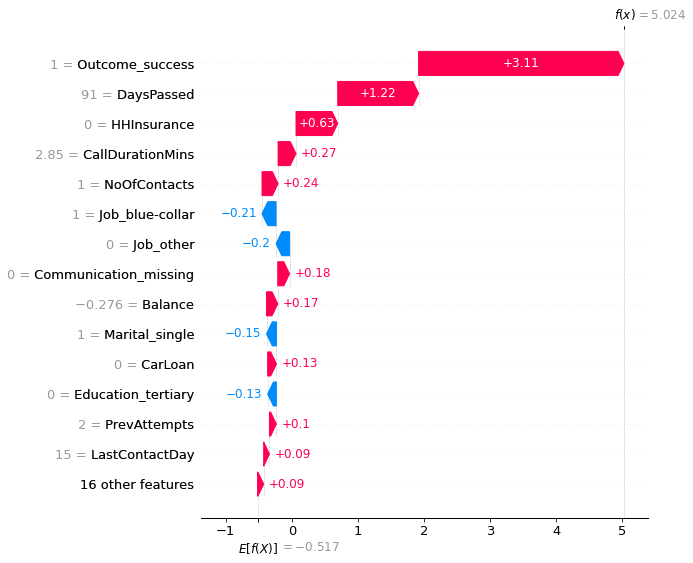

In [60]:
import shap
import pandas as pd
explainer = shap.Explainer(clf.named_steps["model"])
X_test_df = pd.DataFrame(clf.named_steps['pre_processing'].transform(X_test), columns=names)
shap_values = explainer(X_test_df)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[4], max_display=15)

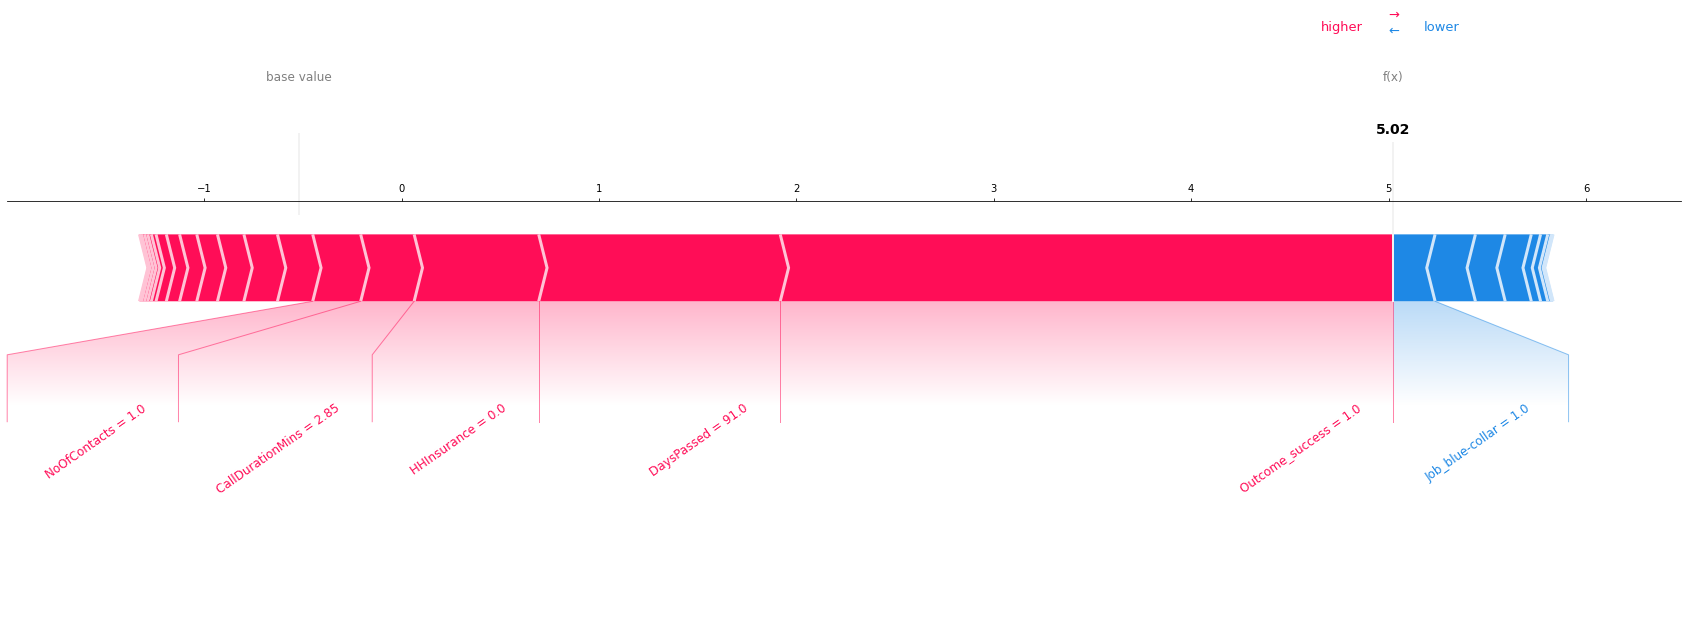

In [58]:
p = shap.plots.force(shap_values[4])
p.matplotlib((30,8),True, 35)

In [69]:
display(accuracy_score(y_test, preds))
conf_matrix = confusion_matrix(y_test, preds)
TP = conf_matrix[0,0]
TN = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
TP / (TP + 0.5 * (FP + FN))

0.8175

0.8494845360824742

In [65]:
clf.predict_proba(X_test)[:,0]

array([4.36414421e-01, 1.83007717e-02, 9.54648018e-01, 7.35162497e-02,
       6.53755665e-03, 9.99594271e-01, 8.90581071e-01, 9.99201179e-01,
       2.85898447e-01, 4.74228323e-01, 4.54505324e-01, 9.87903118e-01,
       7.89329648e-01, 8.65833759e-02, 9.46882784e-01, 1.41324580e-01,
       9.67250168e-01, 8.59719515e-03, 9.99718666e-01, 3.88005376e-01,
       9.95422781e-01, 9.63118553e-01, 1.89399719e-03, 6.49238646e-01,
       4.07879949e-02, 9.37330246e-01, 9.95630383e-01, 6.14523888e-04,
       9.09738779e-01, 9.98929501e-01, 9.99408662e-01, 9.89293635e-01,
       9.88367081e-01, 9.99266267e-01, 6.68926358e-01, 1.80035949e-01,
       9.97761905e-01, 4.68029380e-02, 9.98245358e-01, 9.96904671e-01,
       3.55893791e-01, 3.29052210e-02, 4.25943077e-01, 1.19714737e-02,
       9.78793979e-01, 3.32146049e-01, 9.66578722e-03, 9.75829959e-01,
       9.99571145e-01, 9.82645273e-01, 9.99480307e-01, 9.89769220e-01,
       9.96977329e-01, 9.81445312e-01, 5.12647390e-01, 2.87125111e-02,
      